<a href="https://colab.research.google.com/github/schwarzg/gdg_sigongmo/blob/schwarzg/schwarzg/RNN/RNN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

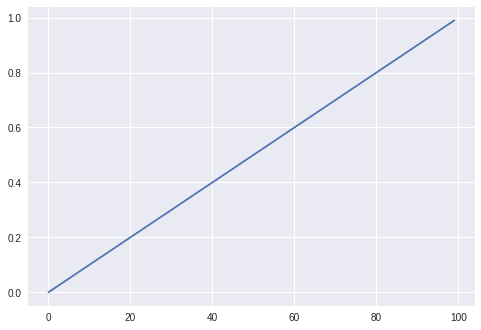

In [0]:
#Prepare test data
def gen_sin(tlen):
  noise=0.1*np.random.normal(size=tlen)
  #return np.sin(np.arange(0,2.*np.pi,2.*np.pi/tlen))+noise
  return np.arange(tlen)/float(tlen)

tlen=100
sindat=gen_sin(tlen)

plt.plot(np.arange(tlen),sindat)

In [0]:
#Preprocess data
tau=10
idim=1
x_tr=[]
y_tr=[]
for i in range(0,tlen-tau):
  x_tr.append(sindat[i:i+tau])
  y_tr.append(sindat[i+tau])
X_tr=np.array(x_tr).reshape(len(x_tr),tau,idim)
Y_tr=np.array(y_tr).reshape(len(y_tr),idim)
Ndat=len(x_tr)

print X_tr.shape
print Y_tr.shape


(90, 10, 1)
(90, 1)


In [0]:
#Construct Network

#define activation functions as hypertanget function
def act(x):
  return np.tanh(x)
def dact(x):
  return 1.0-np.square(np.tanh(x))

#Feedfoward though time. the dimension of h should satisfy (tlen+1,hidden dim)
def feedfoward(x,U,W,V,b,c):
  Ndat=len(x)
  h=np.zeros((Ndat,tau+1,hdim)) #h[-1]=h[tau] means hidden in t=-1, set to zero
  z=np.zeros(h.shape)
  y=np.zeros((Ndat,idim))
  for i in range(0,tau):
    z[:,i,:]=np.dot(x[:,i,:],U)+np.dot(h[:,i-1,:],W)+b
    h[:,i,:]=act(z[:,i,:])
  y[:]=np.dot(h[:,tau-1,:],V)+c
  return [y,z,h]

#cost function : cross entropy
def cost_ms(y,yt):
  return 0.5*np.mean(np.square(y-yt))

#Backpropagation through time
def BPTT(x,yt,U,W,V,b,c,mode):
  Ndat=len(x)
  y,z,h=feedfoward(x,U,W,V,b,c)
  dEdU=np.shape(U.shape)
  dEdW=np.shape(W.shape)
  dEdV=np.shape(V.shape)
  dEdb=np.shape(b.shape)
  dEdc=np.shape(c.shape)
  del_o=y-yt
  t=tau
  dEdV+=np.dot(h[:,t-1,:].transpose(),del_o)/Ndat
  dEdc+=np.mean(del_o,axis=0)
  del_h=np.dot(np.multiply(del_o,1-h[:,t,:]**2),V.transpose())  
  for i in range(t)[::-1]:
    dEdW+=np.dot(h[:,i-1,:].transpose(),del_h)/Ndat
    dEdU+=np.dot(x[:,i,:].transpose(),del_h)/Ndat
    dEdb+=np.mean(del_h,axis=0)
    del_h=np.dot(np.multiply(del_h,1-h[:,i-1,:]**2),W.transpose())
  return [dEdU,dEdW,dEdV,dEdb,dEdc]

0 0.18149544830417716 0.13877615266754967 [[-0.00426305]] [[0.00249889]] [[0.0128941]] [[0.00083935]] [[0.00934342]] [[1.99542317]] [[2.00001344]] [[2.00106244]] [1.99307565] [1.46432479] 0.009312389667067057 0.1
100 0.22177760894023907 0.1883945154962253 [[-0.085111]] [[-0.07831177]] [[-0.06881834]] [[-0.08002626]] [[-0.0713464]] [[2.02511553]] [[1.99518592]] [[2.07578152]] [2.03887042] [1.39163427] -0.06511039490036225 0.1
200 0.2627115605921001 0.2483813926570465 [[-0.18754841]] [[-0.18036997]] [[-0.17126913]] [[-0.18262305]] [[-0.17251907]] [[2.06291974]] [[1.97526911]] [[2.16959353]] [2.09921322] [1.32286234] -0.12375322926682977 0.1
300 0.29762911149306925 0.24086178663777075 [[-0.28448246]] [[-0.27621739]] [[-0.268163]] [[-0.27996259]] [[-0.26661124]] [[2.09789268]] [[1.94613733]] [[2.25050026]] [2.15614476] [1.27641966] -0.16998177999528702 0.1
400 0.3098285322192029 0.33562994145908237 [[-0.37364957]] [[-0.36344353]] [[-0.35730472]] [[-0.36978211]] [[-0.35168266]] [[2.12911232

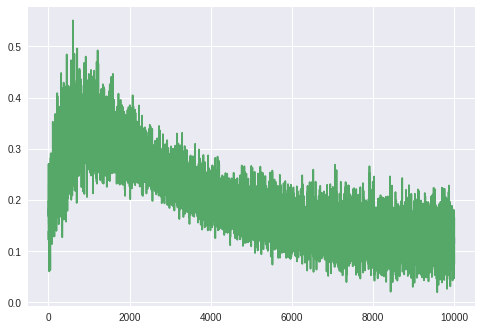

In [0]:
#define weight matrices, hidden nodes
hdim=1
U=0.01*np.random.normal(size=(idim,hdim))
W=0.01*np.random.normal(size=(hdim,hdim))
V=0.01*np.random.normal(size=(hdim,idim))
b=0.01*np.random.normal(size=(1,hdim))
c=0.01*np.random.normal(size=(1,idim))

#start learning
nep=10000
percent=nep/100
lr=0.001
b1=0.99
b2=0.999
mU=np.zeros_like(U)
vU=np.zeros_like(U)
mW=np.zeros_like(W)
vW=np.zeros_like(W)
mV=np.zeros_like(V)
vV=np.zeros_like(V)
mb=np.zeros_like(b)
vb=np.zeros_like(b)
mc=np.zeros_like(c)
vc=np.zeros_like(c)

tcst=[]
vcst=[]
nbatch=10
nval=int(0.1*Ndat)
index=np.arange(Ndat)
for epoch in range(nep+1):
  np.random.shuffle(index)
  
  y,_,_=feedfoward(X_tr[index[nval:],:,:],U,W,V,b,c)
  tcst.append(cost_ms(y,Y_tr[index[nval:],:]))
  yv,_,_=feedfoward(X_tr[index[:nval],:,:],U,W,V,b,c)
  vcst.append(cost_ms(yv,Y_tr[index[:nval],:]))
  
  gU,gW,gV,gb,gc=BPTT(X_tr,Y_tr,U,W,V,b,c,epoch%percent)
  
  if epoch%percent is 0:
    print epoch, tcst[epoch],vcst[epoch],U,W,V,b,c,gU,gW,gV,gb,gc,y[0,0],Y_tr[0,0]
  
  #Adam optimizer
  mU=b1*mU+(1-b1)*gU
  vU=b2*vU+(1-b2)*np.square(gU)	
  mU_h=mU/(1-b1**(i+1))
  vU_h=vU/(1-b2**(i+1))

  mW=b1*mW+(1-b1)*gW
  vW=b2*vW+(1-b2)*np.square(gW)	
  mW_h=mW/(1-b1**(i+1))
  vW_h=vW/(1-b2**(i+1))
  
  mV=b1*mU+(1-b1)*gV
  vV=b2*vU+(1-b2)*np.square(gV)	
  mV_h=mV/(1-b1**(i+1))
  vV_h=vV/(1-b2**(i+1))
  
  mb=b1*mb+(1-b1)*gb
  vb=b2*vb+(1-b2)*np.square(gb)	
  mb_h=mb/(1-b1**(i+1))
  vb_h=vb/(1-b2**(i+1))
  
  mc=b1*mc+(1-b1)*gc
  vc=b2*vc+(1-b2)*np.square(gc)	
  mc_h=mc/(1-b1**(i+1))
  vc_h=vc/(1-b2**(i+1))
  
  #update
  U-=lr*np.divide(mU_h,np.sqrt(vU_h)+1e-8)
  W-=lr*np.divide(mW_h,np.sqrt(vW_h)+1e-8)
  V-=lr*np.divide(mV_h,np.sqrt(vV_h)+1e-8)
  b-=lr*np.divide(mb_h,np.sqrt(vb_h)+1e-8)
  c-=lr*np.divide(mc_h,np.sqrt(vc_h)+1e-8)

plt.plot(np.arange(len(tcst)),tcst)
plt.plot(np.arange(len(vcst)),vcst)
plt.show()

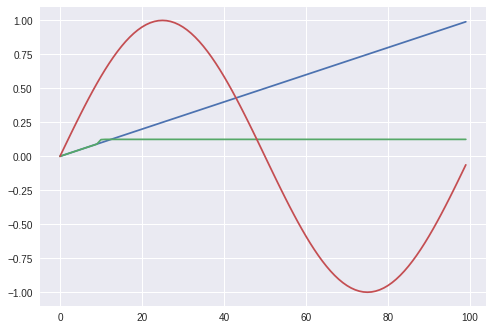

In [0]:
#Test
Ndat=1
X_ts=np.array(sindat[:tau]).reshape((Ndat,tau,idim))
Y_ts=X_ts.reshape(tau)
for i in np.arange(0,tlen-tau):
  y,_,_=feedfoward(X_ts,U,W,V,b,c)
  Y_ts=np.append(Y_ts,y)
  X_ts=np.append(X_ts,y)[1:].reshape((Ndat,tau,idim))
  

plt.plot(np.arange(len(sindat)),sindat)
plt.plot(np.arange(len(Y_ts)),Y_ts)
plt.plot(np.arange(tlen),np.sin(np.arange(0,2.*np.pi,2.*np.pi/tlen)))